#### Imports:

In [186]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer

In [114]:
# Reading in data, and checking that it looks ok:
cleaned_title = pd.read_csv('./data/cleaned_data.csv')
print(cleaned_title.shape)
cleaned_title.head(3)

(9658, 14)


,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string
0,In what condition would the atmosphere have to...,0,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,0,in what condition would the atmosphere have to...,in what condit would the atmospher have to be ...
1,Has anyone here been personally affected by a ...,26,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,0,has anyone here been personally affected by a ...,ha anyon here been person affect by a major cl...
2,A prolonged and record heat wave builds over t...,54,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,1,a prolonged and record heat wave builds over t...,a prolong and record heat wave build over the ...


In [115]:
# Checking for null values:
cleaned_title.isnull().sum()

title            0
score            0
subreddit        0
url              0
num_comments     0
body             0
created          0
date             0
abv_median       0
title_len        0
body_len         0
external_link    0
title_clean      3
stem_string      3
dtype: int64

In [116]:
# Dropping null values in 'title_clean'
i = cleaned_title[(cleaned_title.title_clean.isnull())].index
cleaned_title.drop(i, inplace=True)

In [117]:
cleaned_title.isnull().sum()

title            0
score            0
subreddit        0
url              0
num_comments     0
body             0
created          0
date             0
abv_median       0
title_len        0
body_len         0
external_link    0
title_clean      0
stem_string      0
dtype: int64

# Modeling:
Baseline - As a reminder, I am trying to make more accurate predictions than just predicting the majority class - which is that a post has 5 or fewer comments (52.5% of posts).

#### Test-Train_Split

In [118]:
X = cleaned_title['stem_string']
y = cleaned_title['abv_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.75, random_state=42)

## Title text only:

### CountVectorizer:

In [119]:
# I also tried using these hyperparameters, but they didn't improve the model: stop_words='english', binary=True, ngram_range=(1,2)
cv= CountVectorizer(binary=True)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [120]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=10)
dtc.fit(X_train_cv, y_train)
dtc.score(X_train_cv, y_train), dtc.score(X_test_cv, y_test)

(0.6094462090871426, 0.5658657829328915)

In [121]:
abc = AdaBoostClassifier(random_state=42, n_estimators=150)

abc.fit(X_train_cv, y_train)
abc.score(X_train_cv, y_train), abc.score(X_test_cv, y_test)

(0.655572434746582, 0.5932062966031483)

In [122]:
random_forest_params = {
    'max_depth' : [None, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'n_estimators': [100, 125, 150]
    
}

gs = GridSearchCV(
    RandomForestClassifier(), param_grid=random_forest_params, verbose=1)

gs.fit(X_train_cv, y_train)

print(gs.best_score_, gs.best_params_)

gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test)

In [123]:
cv_vocab = cv.get_feature_names_out()

ft_imp_df = pd.DataFrame(
    abc.feature_importances_,
    index=cv_vocab,
    columns=['ft imps']
)

In [125]:
# Only 150 of the 6906 features were factored in
len(abc.feature_importances_), sum(ft_imp_df['ft imps'] != 0)

(6906, 150)

In [127]:
ft_imp_df[ft_imp_df['ft imps'] != 0].sort_values(by='ft imps', ascending=True).head()

,ft imps
1970,0.006667
pari,0.006667
penguin,0.006667
podcast,0.006667
polici,0.006667


In [129]:
ft_imp_df[ft_imp_df['ft imps'] != 0].sort_values(by='ft imps', ascending=False).head()

,ft imps
1970,0.006667
or,0.006667
pari,0.006667
penguin,0.006667
podcast,0.006667


**Interpretation** of feature importances above:

All 150 features that were not set to 0 were scored at equal weight.

In [130]:
rfc = RandomForestClassifier(random_state=42, min_samples_leaf=3, n_estimators=100)
rfc.fit(X_train_cv, y_train)
rfc.score(X_train_cv, y_train), rfc.score(X_test_cv, y_test)

(0.7686783593426322, 0.5985915492957746)

In [131]:
# This is the best performing model for text so far -
pipe = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2))),
    ('ss', StandardScaler(with_mean=False)),
    ('rfc', RandomForestClassifier(random_state=42, min_samples_leaf=3, n_estimators=100)),
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.7713023063112829, 0.6014913007456504)

In [132]:
pipe_vocab = pipe['cv'].get_feature_names_out()

pipe_ft_imp_df = pd.DataFrame(
    pipe['rfc'].feature_importances_,
    index=pipe_vocab,
    columns=['ft imps']
)

In [83]:
len(pipe['rfc'].feature_importances_), sum(pipe_ft_imp_df['ft imps'] != 0)

(46369, 3745)

In [85]:
# These are the most impactful features that the model has identified for whether a post will be abv_median:
pipe_ft_imp_df[pipe_ft_imp_df['ft imps'] != 0].sort_values(by='ft imps', ascending=False).head(10)

,ft imps
what,0.013108
co2,0.007906
is,0.006822
trump,0.006733
my,0.006662
are,0.005794
about,0.005342
question,0.005176
are we,0.004923
skeptic,0.004571


In [86]:
# And the smallest, yet non-zero, features:
pipe_ft_imp_df[pipe_ft_imp_df['ft imps'] != 0].sort_values(by='ft imps', ascending=True).head(10)

,ft imps
atlant meridion,2.270379e-08
is global,3.487944e-08
oil industri,6.636940e-08
cope with,6.906445e-08
get better,1.780416e-07
vegan,2.440160e-07
question for,2.554893e-07
about to,3.107698e-07
noth about,4.330478e-07
give me,4.807405e-07


Recorded scores from various trials done on Decision Tree, Random Forest, and AdaBoost classifier models:
(the format is modelname: train score, test score)

scores from text_clean, ngram_range(1,2)

* DTC: .996 .531
* RFC: .765 .598
* ABC: .676 .603

scores from text_clean, stop_words='english', binary=True, ngram_range=(1,2):

* DTC: .993 .558
* RFC: .756 .580
* ABC: .646 .555

scores from stem_string, all default:

* DTC: .996 .549
* RFC: .765 .604
* ABC: .670 .600

scores from stem_string, ngram_range=(1,2)

* DTC: .996 .548
* RFC: .770 .609
* ABC: .674 .596

### TfidVectorizer:

In [54]:
tf = TfidfVectorizer(ngram_range=(1,2)) #stop_words="english", 

# fit & transform
tf.fit(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [177]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_tf, y_train)
dtc.score(X_train_tf, y_train), dtc.score(X_test_tf, y_test)

(0.995580720894904, 0.5430820215410108)

In [178]:
rfc = RandomForestClassifier(random_state=42, min_samples_leaf=3, n_estimators=100)
rfc.fit(X_train_tf, y_train)
rfc.score(X_train_tf, y_train), rfc.score(X_test_tf, y_test)

(0.8348294434470377, 0.5782932891466446)

In [153]:
abc = AdaBoostClassifier(random_state=42, n_estimators=150)

abc.fit(X_train_tf, y_train)
abc.score(X_train_tf, y_train), abc.score(X_test_tf, y_test)

(0.6914790774754868, 0.5654515327257663)

In [144]:
# Inspiration from: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
X = cleaned_title['stem_string']
y = cleaned_title['abv_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.75, random_state=42)

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [150]:
nb.score(X_train, y_train), nb.score(X_test, y_test)

(0.8121806380334208, 0.5907207953603977)

In [145]:
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5907207953603977
              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1266
           1       0.57      0.58      0.57      1148

    accuracy                           0.59      2414
   macro avg       0.59      0.59      0.59      2414
weighted avg       0.59      0.59      0.59      2414

CPU times: user 39.1 ms, sys: 3.35 ms, total: 42.5 ms
Wall time: 41.7 ms


In [146]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=200, n_jobs=1)),
               ])

logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=200, n_jobs=1))])

In [147]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.7750310730562077, 0.5907207953603977)

In [148]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5907207953603977
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      1266
           1       0.58      0.50      0.54      1148

    accuracy                           0.59      2414
   macro avg       0.59      0.59      0.59      2414
weighted avg       0.59      0.59      0.59      2414

CPU times: user 35.7 ms, sys: 2.43 ms, total: 38.1 ms
Wall time: 37.6 ms


## Other (non-text) Features:

In [89]:
cleaned_title.columns

Index(['title', 'score', 'subreddit', 'url', 'num_comments', 'body', 'created',
       'date', 'abv_median', 'title_len', 'body_len', 'external_link',
       'title_clean', 'stem_string'],
      dtype='object')

In [90]:
features = ['score', 'title_len', 'body_len', 'external_link']

In [164]:
X = cleaned_title[features]
y = cleaned_title['abv_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

In [92]:
feat_logreg = Pipeline([('ss', StandardScaler()),
                ('lr', LogisticRegression(max_iter=200, n_jobs=1)),
               ])

In [93]:
feat_logreg.fit(X_train, y_train)
feat_logreg.score(X_train, y_train), feat_logreg.score(X_test, y_test)

(0.6398287529346776, 0.6317315658657829)

In [94]:
y_pred = feat_logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6317315658657829
              precision    recall  f1-score   support

           0       0.65      0.62      0.64      1254
           1       0.61      0.65      0.63      1160

    accuracy                           0.63      2414
   macro avg       0.63      0.63      0.63      2414
weighted avg       0.63      0.63      0.63      2414



In [142]:
# Looking at logistic regression coefficients for numeric features:
coefs = feat_logreg['lr'].coef_

num_ft_imp_df = pd.DataFrame(
    coefs,
    columns=features
)

num_ft_imp_df

,score,title_len,body_len,external_link
0,0.681998,0.098498,0.167752,-0.435614


Interpretation: score, title length, body length are positively correlated with likelihood of receiving more than 5 comments, and if it's an external link, that is negatively correlated with likelihood of receiving more than 5 comments. 

In [166]:
rfc2 = RandomForestClassifier(random_state=42, min_samples_leaf=3, n_estimators=100)
rfc2.fit(X_train, y_train)
rfc2.score(X_train, y_train), rfc2.score(X_test, y_test)

(0.7989228007181328, 0.6064623032311516)

In [168]:
abc2 = AdaBoostClassifier(random_state=42, n_estimators=150)

abc2.fit(X_train, y_train)
abc2.score(X_train, y_train), abc2.score(X_test, y_test)

(0.6601298163237121, 0.6317315658657829)

In [169]:
y_pred = abc2.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6317315658657829
              precision    recall  f1-score   support

           0       0.64      0.67      0.66      1254
           1       0.62      0.59      0.61      1160

    accuracy                           0.63      2414
   macro avg       0.63      0.63      0.63      2414
weighted avg       0.63      0.63      0.63      2414



## Text AND other features:

Using ColumnTransformer and FunctionTransformer to apply different transformations to different columns:

In [171]:
# Inspiration from: https://stackoverflow.com/questions
# /61179217/sklearn-pipeline-all-the-input-array-dimensions-for-the-concatenation-axis-must

vectorizer_params = dict(ngram_range=(1, 2), binary=True)

TitleTextProcessor = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('title', TitleTextProcessor, ['stem_string']),
    ('numeric', numeric_transformer, ['score', 'title_len', 'body_len', 'external_link'])
])

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(max_iter=200, random_state=42))]
)

In [171]:
X = cleaned_title[['stem_string', 'score', 'title_len', 'body_len', 'external_link']]
y = cleaned_title['abv_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.75, random_state=42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('title',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7ffde6f860d0>)),
                                                                  ('vect',
                                                                   CountVectorizer(binary=True,
                                                                                   ngram_range=(1,
                                                                                                2))),
                                                                  ('tfidf',
                                                                   TfidfTransformer()),
                                                                  ('toarray',
                                                                   FunctionTransform

In [172]:
print("Model score: %.3f" % pipeline.score(X_test, y_test))

Model score: 0.661


In [173]:
y_pred = pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6607290803645401
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1266
           1       0.66      0.60      0.63      1148

    accuracy                           0.66      2414
   macro avg       0.66      0.66      0.66      2414
weighted avg       0.66      0.66      0.66      2414

CPU times: user 911 ms, sys: 610 ms, total: 1.52 s
Wall time: 1.16 s


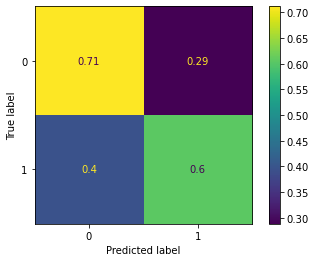

In [184]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize='true');

In [187]:
tn, fp, fn, tp = confusion_matrix(y_test, pipeline.predict(X_test)).flatten()
tn, fp, fn, tp 

(901, 365, 454, 694)

In [193]:
print('Recall score: ', (tp / (tp + fn)))
print('Precision score: ', (tp / (tp + fp)))
print('False Positive rate: ', (fp / (tn + fp)))

Recall score:  0.6045296167247387
Precision score:  0.6553352219074599
False Positive rate:  0.2883096366508689


**Interpretation**:
Our model's best classification metric is specificity -  the true negative of when a post would get fewer than the median amounts of comments. 

For recall, or the true positive rate, our model scored a 60.5% which means that ~60% of posts with over 5 comments were identified.
For precision, or the proportion that are actually positive of all the things I predicted were, our model scored 65.5% which means that ~65% of positive predictions were correct.

Since this is not a life or death scenario, there was no preference given to whether false positives or false negatives were identified, and I was just aiming to achieve highest accuracy overall.